In [6]:
import argparse
import scipy
from sklearn.externals import joblib
import math

import pandas as pd

from sklearn import preprocessing
from sklearn_pandas import gen_features
from sklearn_pandas import DataFrameMapper

from sklearn import ensemble
import sklearn
import numpy as np
from matplotlib import pyplot as plt
from preprocessing import ChooseFeatureColumns
from preprocessing import MyMapper
import ast
import os
import skgarden

import mysql.connector
from tabulate import tabulate

In [18]:
def remove_bad_columns(df):
        parameters = [i for i in list(df) if (i.startswith("parameters.") and not i.startswith("parameters.__job_r"))]
        filetypes=[i for i in list(df) if (i.endswith("_filetype") and not i.startswith("parameters.__job_r"))]
        files=[i[:-9] for i in filetypes]
        bad_parameters=["parameters.__workflow_invocation_uuid__","parameters.chromInfo"]
        for parameter in parameters:
            series=df[parameter].dropna()
            if all(type(item)==str and item.startswith('"') for item in series): 
                try:
                    df[parameter]=df[parameter].str[1:-1].astype(float)
                except:
                    pass
            if len(df[parameter].unique())>=0.5*df.shape[0]:
                bad_parameters.append(parameter)
            if df[parameter].dtype == object and len(df[parameter].unique())>=10*df.shape[1]:
                bad_parameters.append(parameter)
            if all(type(item)==str and item.startswith("[") and item.endswith("]") for item in series):#  and item.startswith("[{'src'")
                if all(type(ast.literal_eval(item))==list for item in series):
                    bad_parameters.append(parameter)
        for file in files:
            bad_parameters.append("parameters."+file)
            bad_parameters.append("parameters."+file+".values")
            bad_parameters.append("parameters."+file+"|__identifier__")
        for param in set(bad_parameters):
            try:
                parameters.remove(param)
            except:
                pass
        hardware=[
#              'destination_id',
#          'galaxy_slots',
#          'handler',
#          'job_runner_name',
#          'memtotal',
#          'processor_count',
         'result']
        keep=parameters+filetypes+files+hardware
        columns=list(df)
        for column in columns:
            if not column in keep:
                del df[column]
        return df

In [19]:
filename="devteam_clustalw_clustalw_0.1"
df=pd.read_csv("../data/csv_dump/%s.csv"%filename)
df2=pd.read_csv("walltime_csv/%s.csv"%filename)
df["result"], df2["result"]="ok", "walltime error"
df.index=df["id"]
df2.index=df2["id"]
df=pd.concat([df,df2])
df=df.sort_values("id")
del df["id"]
df=df.reset_index()
del df["id"]
df=remove_bad_columns(df)
df=remove_bad_columns(df)

/Users/atyrysh/development/ber1/.venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
from sklearn import dummy
chooser = ChooseFeatureColumns()
scaler = MyMapper()
regr=sklearn.ensemble.RandomForestClassifier(n_estimators=100, max_depth=12, max_features=None)
# regr=sklearn.dummy.DummyClassifier()
pipe = sklearn.pipeline.Pipeline([
    ('chooser',chooser),
    ('scaler', scaler),
])

test_size = 0.2

In [27]:
def get_prediction_metrics(df, benchmarks):
    benches={}
    benches["samples"]=df.shape[0]
    benches["num_errors"]=df["result"].value_counts()["walltime error"]
    df2=df.copy()
#     print(df2["job_runner_name"].value_counts())
    df_features, df_labels = df2, df2.pop("result")

    test_start=len(df_labels)-int(len(df_labels)*test_size)

    split_randomly=False
    time_split=True
    if split_randomly and time_split:
        tr_features, ev_features, tr_labels, ev_labels = sklearn.model_selection.train_test_split(df_features, df_labels, test_size=test_size)
#         print("splitting randomly")
    elif time_split:
        tr_features, tr_labels, ev_features, ev_labels = df_features[:test_start], df_labels[:test_start], df_features[test_start:], df_labels[test_start:]
#         print("splitting non-randomly")
    if time_split and ((len(list(pipe.fit_transform(tr_features)))) != (len(list(pipe.transform(ev_features))))):
#         print("!! pipe transformation broken")
        time_split=False
    df_features=pipe.fit_transform(df_features)
    if time_split:
            tr_features=pipe.fit_transform(tr_features)
            ev_features=pipe.transform(ev_features)
    regr.fit(tr_features,tr_labels)
    ev_pred = regr.predict(ev_features)
    accuracy=sklearn.metrics.accuracy_score(ev_labels,ev_pred) 
    benches["accuracy_time_split"]=accuracy
#     print(df_features["job_runner_name"].value_counts())
    
    regr.fit(df_features, df_labels)
    pred=regr.predict(df_features)
    accuracy=sklearn.metrics.accuracy_score(df_labels,pred) 
    benches["accuracy"]=accuracy
    benchmarks.append(benches)
    return benchmarks
# benchmarks, df_features=get_prediction_metrics(df, [])


In [ ]:
benchmarks=[]
ar=np.arange(100,df.shape[0], 100)
for i in ar:
    print("%d/%d"%(i, ar[-1]))
    benchmarks=get_prediction_metrics(df.sample(i), benchmarks)
print("done")

In [25]:
fi=dict(zip(list((df_features)),regr.feature_importances_))

import operator
sorted(fi.items(), key=operator.itemgetter(1), reverse=True)

[('input', 0.7088908479475485),
 ('destination_id_slurm_single', 0.041607365725413514),
 ('parameters.outcontrol.outform_phylip', 0.014855723285576283),
 ('parameters.dbkey_"?"', 0.013510034293520776),
 ('handler_main_w2_handler0', 0.012358125420418094),
 ('destination_id_slurm_normal', 0.012245110001748029),
 ('handler_main_w4_handler0', 0.012241476808190955),
 ('handler_main_w3_handler0', 0.011759545575624393),
 ('parameters.outcontrol.out_seqnos_OFF', 0.011419253265126262),
 ('handler_main_w1_handler1', 0.009897267702101881),
 ('handler_main_w4_handler1', 0.00936095987490811),
 ('parameters.dbkey_"hg19"', 0.0093334749992916),
 ('handler_main_w3_handler1', 0.009212209835430162),
 ('parameters.outcontrol.out_seqnos_ON', 0.009121816985132649),
 ('handler_main_w1_handler0', 0.008901951961236056),
 ('destination_id_reserved', 0.007160446886551027),
 ('destination_id_rodeo_normal', 0.006859693956653079),
 ('handler_main_w2_handler1', 0.006720768321112763),
 ('handler_main_w1_handler2', 0.

In [36]:
benchmarks2=[]
ar=np.arange(100,df[df["result"]=="walltime error"].shape[0], 50)
for i in ar:
    print("%d/%d"%(i, ar[-1]))
    edf=df[df["result"]=="walltime error"].sample(i)
    odf=df[df["result"]=="ok"].sample(i)
    tdf=pd.concat([edf,odf])
    tdf.sort_index(inplace=True)
    benchmarks2=get_prediction_metrics(tdf, benchmarks2)
print("done")

100/450
150/450
200/450
250/450
300/450
350/450
400/450
450/450
done


In [33]:
benchmarks=[]
ar=np.arange(100,df.shape[0], 100)
for i in ar:
    print("%d/%d"%(i, ar[-1]))
    benchmarks=get_prediction_metrics(df.sample(i), benchmarks)
print("done")

100/17600
200/17600
300/17600
400/17600
500/17600
600/17600
700/17600
800/17600
900/17600
1000/17600
1100/17600
1200/17600
1300/17600
1400/17600
1500/17600
1600/17600
1700/17600
1800/17600
1900/17600
2000/17600
2100/17600
2200/17600
2300/17600
2400/17600
2500/17600
2600/17600
2700/17600
2800/17600
2900/17600
3000/17600
3100/17600
3200/17600
3300/17600
3400/17600
3500/17600
3600/17600
3700/17600
3800/17600
3900/17600
4000/17600
4100/17600
4200/17600
4300/17600
4400/17600
4500/17600
4600/17600
4700/17600
4800/17600
4900/17600
5000/17600
5100/17600
5200/17600
5300/17600
5400/17600
5500/17600
5600/17600
5700/17600
5800/17600
5900/17600
6000/17600
6100/17600
6200/17600
6300/17600
6400/17600
6500/17600
6600/17600
6700/17600
6800/17600
6900/17600
7000/17600
7100/17600
7200/17600
7300/17600
7400/17600
7500/17600
7600/17600
7700/17600
7800/17600
7900/17600
8000/17600
8100/17600
8200/17600
8300/17600
8400/17600
8500/17600
8600/17600
8700/17600
8800/17600
8900/17600
9000/17600
9100/17600
9200/176

KeyboardInterrupt: 

In [37]:
df2=pd.DataFrame(benchmarks2)

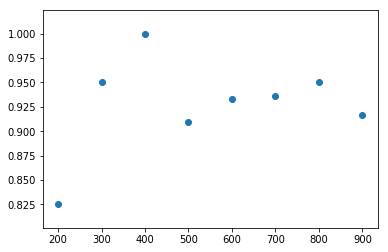

In [40]:
from matplotlib import pyplot as plt
plt.scatter(df2["samples"], df2["accuracy_time_split"])

In [31]:
df2

,accuracy,accuracy_time_split,num_errors,samples
0,1.000000,1.000000,2,100
1,1.000000,0.975000,4,200
2,1.000000,1.000000,4,300
3,1.000000,0.987500,11,400
4,1.000000,0.980000,15,500
5,1.000000,0.983333,11,600
6,1.000000,0.978571,21,700
7,1.000000,0.987500,21,800
8,1.000000,0.972222,17,900
9,1.000000,0.960000,21,1000


In [90]:
wedf=df[df["result"]=="walltime error"]
wedf["job_runner_name"].value_counts()

slurm    452
Name: job_runner_name, dtype: int64

In [92]:
df["job_runner_name"].value_counts()

slurm    17634
Name: job_runner_name, dtype: int64

In [91]:
okdf=df[df["result"]=="ok"]
okdf["job_runner_name"].value_counts()

slurm    17182
Name: job_runner_name, dtype: int64

In [12]:
len(regr.feature_importances_)

162

In [13]:
len(list(df_features))

162

In [16]:
fi=dict(zip(list((df_features)),regr.feature_importances_))

In [17]:
import operator
sorted(fi.items(), key=operator.itemgetter(1), reverse=True)

[('processor_count', 1.0),
 ('chromInfo', 0.0),
 ('input', 0.0),
 ('parameters.outcontrol.__current_case__', 0.0),
 ('parameters.range.__current_case__', 0.0),
 ('parameters.range.seq_range_end', 0.0),
 ('parameters.range.seq_range_start', 0.0),
 ('chromInfo_filetype_len', 0.0),
 ('chromInfo_filetype_nan', 0.0),
 ('destination_id_reserved', 0.0),
 ('destination_id_rodeo_normal', 0.0),
 ('destination_id_roundup_single', 0.0),
 ('destination_id_slurm_normal', 0.0),
 ('destination_id_slurm_single', 0.0),
 ('handler_main_w1_handler0', 0.0),
 ('handler_main_w1_handler1', 0.0),
 ('handler_main_w1_handler2', 0.0),
 ('handler_main_w2_handler0', 0.0),
 ('handler_main_w2_handler1', 0.0),
 ('handler_main_w3_handler0', 0.0),
 ('handler_main_w3_handler1', 0.0),
 ('handler_main_w4_handler0', 0.0),
 ('handler_main_w4_handler1', 0.0),
 ('input_filetype_Sequences', 0.0),
 ('input_filetype_bam', 0.0),
 ('input_filetype_bed', 0.0),
 ('input_filetype_data', 0.0),
 ('input_filetype_fasta', 0.0),
 ('input_f

In [22]:
df

,chromInfo,chromInfo_filetype,destination_id,handler,input,input_filetype,parameters.dbkey,parameters.dnarna,parameters.out_order,parameters.outcontrol.__current_case__,parameters.outcontrol.out_seqnos,parameters.outcontrol.outform,parameters.range.__current_case__,parameters.range.mode,parameters.range.seq_range_end,parameters.range.seq_range_start,processor_count,result
0,NaN,NaN,slurm_single,main_w1_handler1,1201020596,fasta,"""hg19""","""DNA""","""ALIGNED""",0,NaN,fasta,0,complete,NaN,NaN,NaN,walltime error
1,NaN,NaN,slurm_single,main_w2_handler1,21373765,fasta,"""hg19""","""DNA""","""ALIGNED""",2,OFF,clustal,0,complete,NaN,NaN,NaN,walltime error
2,NaN,NaN,slurm_single,main_w1_handler0,21373765,fasta,"""hg19""","""DNA""","""ALIGNED""",2,OFF,clustal,0,complete,NaN,NaN,NaN,walltime error
3,NaN,NaN,slurm_single,main_w2_handler1,8998242,fasta,"""hg19""","""DNA""","""ALIGNED""",2,OFF,clustal,0,complete,NaN,NaN,NaN,walltime error
4,NaN,NaN,slurm_single,main_w1_handler0,12083536,fasta,"""?""","""DNA""","""ALIGNED""",0,NaN,fasta,0,complete,NaN,NaN,NaN,walltime error
5,NaN,NaN,slurm_single,main_w1_handler1,12083536,fasta,"""?""","""DNA""","""ALIGNED""",2,OFF,clustal,0,complete,NaN,NaN,NaN,walltime error
6,NaN,NaN,slurm_single,main_w2_handler0,725845860,fasta,"""mm10""","""DNA""","""ALIGNED""",2,OFF,clustal,0,complete,NaN,NaN,NaN,walltime error
7,NaN,NaN,slurm_single,main_w2_handler0,725845860,fasta,"""mm10""","""DNA""","""ALIGNED""",2,OFF,clustal,0,complete,NaN,NaN,NaN,walltime error
8,NaN,NaN,slurm_single,main_w2_handler0,7313716,fasta,"""?""","""DNA""","""INPUT""",0,NaN,fasta,0,complete,NaN,NaN,NaN,walltime error
9,NaN,NaN,slurm_single,main_w1_handler1,8930356,fasta,"""mycoTube_H37RV""","""DNA""","""ALIGNED""",2,OFF,clustal,0,complete,NaN,NaN,NaN,walltime error
